In [1]:
## run in colab
# from google.colab import drive
# drive.mount('/content/drive')
# ! cp /content/drive/MyDrive/dataset/celeb.zip ./
# ! unzip celeb.zip

Mounted at /content/drive


# DCGAN
* task: image generation
* model:
    1. $G$ take random noise and output a image
    2. $D$ take a image and output a patch
* loss: naive GAN loss

## do some imports

In [5]:
import torch
from torch import nn

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.append("./../utils")
from utils import BasicConv, init_weight, set_seed
set_seed(2022)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## define the model

### $G$'s model
1. gradually decreasing channel and increasing resolution
2. but, in the first conv block, map from noise (N, 100, 1, 1) to init image (N, 512, 4, 4) then follow $1$

In [19]:
class Gen(nn.Module):
    """
    input: (N, 100, 1, 1)
    output: (N, 3, 64, 64)
    """
    def __init__(self, noise_channel=100, img_channel=3) -> None:
        super(Gen, self).__init__()
        # (N, 100, 1, 1)
        main = []
        main.append(UpConv(noise_channel, 512, 4, 1, 0))
        # (N, 512, 4, 4)
        main.append(UpConv(512, 256, 4, 2, 1))
        # (N, 256, 8, 8)
        main.append(UpConv(256, 128, 4, 2, 1))
        # (N, 128, 16, 16)
        main.append(UpConv(128, 64, 4, 2, 1))
        # (N, 64, 32, 32)
        main.append(nn.ConvTranspose2d(64, img_channel, 4, 2, 1))
        # (N, 3, 64, 64)
        self.model = nn.Sequential(*main)
    
    def forward(self, x): 
        return self.model(x)

class UpConv(nn.Module):
    """
    input: (N, in_channel, H, W)
    output: (N, out_channel, 2*H, 2*W)
    """
    def __init__(self, in_channel, out_channel, k_s, s, p) -> None:
        super(UpConv, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, k_s, s, p),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.block(x)

def test_gen():
    model = Gen()
    x = torch.rand(8, 100, 1, 1)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_gen()

model params num:3575747
input sizetorch.Size([8, 100, 1, 1]), output size: torch.Size([8, 3, 64, 64])


### $D$'s model
1. gradually increasing channel of feature map and decreasing resolution
2. in the last conv block, map from 512 channel image to 1 single scalar
   

In [18]:
class Disc(nn.Module):
    """
    input: (N, 3, 64, 64)
    output: (N, 1, 8, 8)
    """
    def __init__(self, img_channel=3):
        super(Disc, self).__init__()
        main = []
        # (N, 3, 64, 64)
        main.append(BasicConv(img_channel, 64, 4, 2, 1))
        # (N, 64, 32, 32)
        main.append(BasicConv(64, 128, 4, 2, 1))
        # (N, 128, 16, 16)
        main.append(BasicConv(128, 256, 4, 2, 1))
        # (N, 256, 8, 8)
        main.append(BasicConv(256, 512, 4, 2, 1))
        # (N, 512, 4, 4)
        main.append(nn.Conv2d(512, 1, 4, 1, 0))
        # (N, 1, 1, 1)
        self.model = nn.Sequential(*main)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.model(x))

def test_disc():
    model = Disc()
    x = torch.rand(8, 3, 64, 64)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_disc()

model params num:2764737
input sizetorch.Size([8, 3, 64, 64]), output size: torch.Size([8, 1, 1, 1])


## define params

In [8]:
l_r_gen = 2e-4
l_r_disc = 2e-4

NUM_EPOCH = 5
BATCH_SIZE = 64

noise_channel = 100
img_channel = 3

fix_noise = torch.randn(16, 100, 1, 1).to(DEVICE)

## prepare data

In [9]:
transform = transforms.Compose([
  transforms.CenterCrop(178),
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])


class CelebDataset(Dataset):
  def __init__(self, transform, data_path="./celeb_dataset/images/"):
    self.data_path = data_path
    self.file_lst = os.listdir(data_path)
    self.transform = transform
    
  def __len__(self):
    return len(self.file_lst)
  
  def __getitem__(self, idx):
    img = Image.open(self.data_path + self.file_lst[idx])
    if self.transform:
      img = self.transform(img)
    return img

In [13]:
celeb_dataset = CelebDataset(transform)
celeb_dataloader = DataLoader(celeb_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### show train data

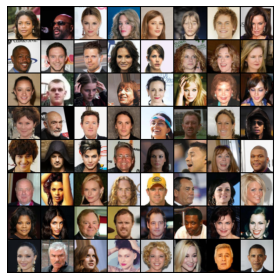

In [14]:
x = next(iter(celeb_dataloader))
img_grid = torchvision.utils.make_grid(x)
plt.imshow(img_grid.permute(1,2,0).numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

## training loop

In [20]:
gen = Gen(noise_channel, img_channel).to(DEVICE)
disc = Disc(img_channel).to(DEVICE)

gen.apply(init_weight)
disc.apply(init_weight)

opt_gen = optim.Adam(gen.parameters(), lr=l_r_gen, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=l_r_disc, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [21]:
real_writer = SummaryWriter(log_dir="./run/DCGAN/real")
fake_writer = SummaryWriter(log_dir="./run/DCGAN/fake")

  0%|          | 0/3166 [00:00<?, ?it/s]

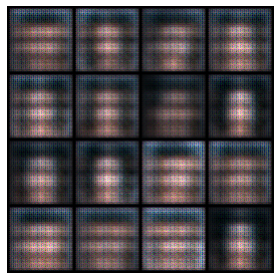

 16%|█▌        | 500/3166 [01:37<08:29,  5.23it/s]

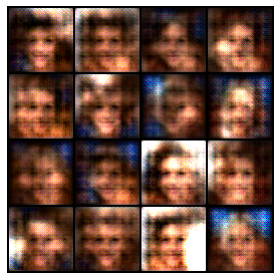

 32%|███▏      | 1000/3166 [03:15<07:01,  5.14it/s]

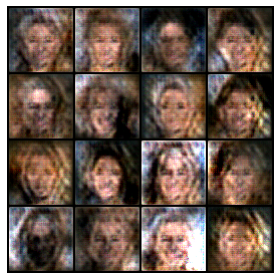

 47%|████▋     | 1500/3166 [04:52<05:19,  5.22it/s]

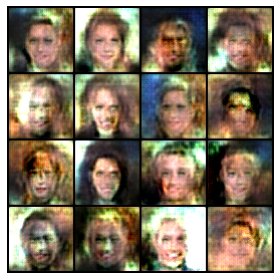

 63%|██████▎   | 2000/3166 [06:30<03:56,  4.94it/s]

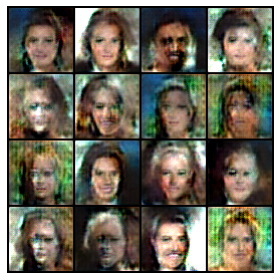

 79%|███████▉  | 2500/3166 [08:07<02:08,  5.20it/s]

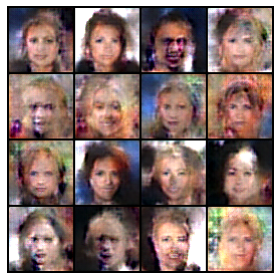

 95%|█████████▍| 3000/3166 [09:45<00:32,  5.15it/s]

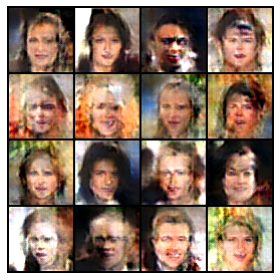

100%|██████████| 3166/3166 [10:18<00:00,  5.12it/s]


epoch:[ 0/ 5], batch[3165/3166], loss:[G:1.542647,D:0.393414]


  0%|          | 0/3166 [00:00<?, ?it/s]

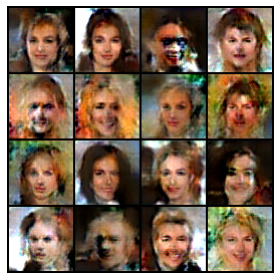

 16%|█▌        | 500/3166 [01:36<08:33,  5.20it/s]

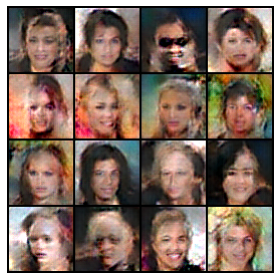

 32%|███▏      | 1000/3166 [03:13<06:58,  5.17it/s]

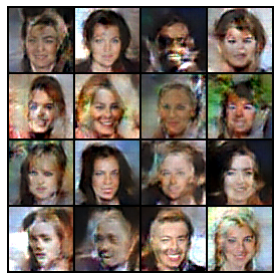

 47%|████▋     | 1500/3166 [04:49<05:22,  5.17it/s]

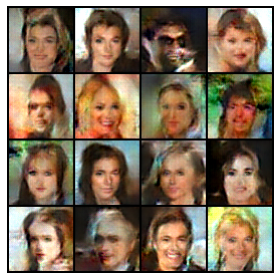

 63%|██████▎   | 2000/3166 [06:26<03:45,  5.17it/s]

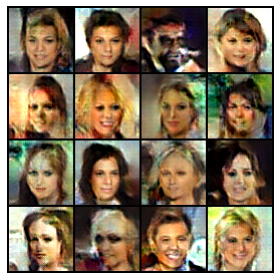

 79%|███████▉  | 2500/3166 [08:03<02:09,  5.13it/s]

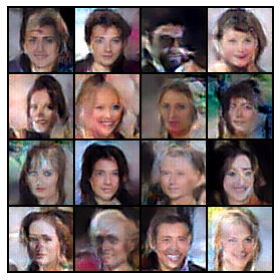

 95%|█████████▍| 3000/3166 [09:39<00:32,  5.14it/s]

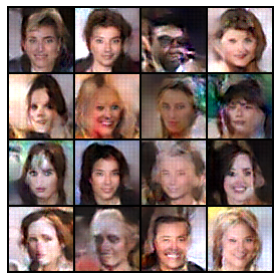

100%|██████████| 3166/3166 [10:11<00:00,  5.17it/s]


epoch:[ 1/ 5], batch[3165/3166], loss:[G:0.733998,D:0.590135]


  0%|          | 0/3166 [00:00<?, ?it/s]

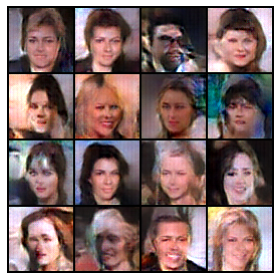

 16%|█▌        | 500/3166 [01:36<08:30,  5.22it/s]

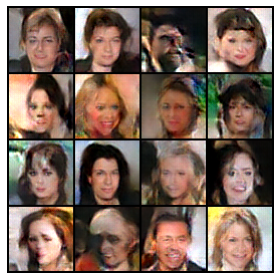

 18%|█▊        | 569/3166 [01:50<08:22,  5.17it/s]


KeyboardInterrupt: ignored

In [24]:
for epoch in range(NUM_EPOCH):
    loop = tqdm(celeb_dataloader, leave=True)
    for batch_idx, (x) in enumerate(loop):
        x = x.to(DEVICE)

        gen.train()
        disc.train()
        noise = torch.randn(BATCH_SIZE, noise_channel, 1, 1).to(DEVICE)
        fake_gen = gen(noise)

        fake_disc = disc(fake_gen).view(-1)
        real_disc = disc(x).view(-1)

        # train discrimnator
        # make fake_gen 0, real_gen 1
        fake_disc_loss = loss(fake_disc, torch.zeros_like(fake_disc))
        real_disc_loss = loss(real_disc, torch.ones_like(real_disc))    
        disc_loss = (fake_disc_loss + real_disc_loss) / 2
        disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()


        # train generator
        # make fake_gen 1
        fake_gen = gen(noise)
        fake_disc = disc(fake_gen).view(-1)
        loss_gen = loss(fake_disc, torch.ones_like(fake_disc))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        if batch_idx % 500 == 0:
          with torch.no_grad():
              fake_out = gen(fix_noise)
              img_grid = torchvision.utils.make_grid(fake_out, nrow=4)
              plt.imshow(img_grid.cpu().permute(1,2,0).numpy())
              plt.axis("off")
              plt.tight_layout()
              plt.show()
    print(f"epoch:[{epoch:>2d}/{NUM_EPOCH:>2d}], batch[{batch_idx:>4d}/{len(celeb_dataloader):>4d}], loss:[G:{loss_gen:>6f},D:{disc_loss:6f}]")
    gen.eval()
    disc.eval()
    # GAN sample real and gen_result
    with torch.no_grad():
      fake_out = gen(fix_noise)
      grid_fake = torchvision.utils.make_grid(fake_out, nrow=4)
      grid_real = torchvision.utils.make_grid(x[:16], nrow=4)
      real_writer.add_image(tag="real", img_tensor=grid_real, global_step=epoch)
      fake_writer.add_image("fake", grid_fake, epoch)